In [4]:
import json, sys, os, warnings, random, string, shutil
import numpy as np
from astropy.io import ascii
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from tqdm import tqdm
import scipy.constants as cons
import xtrack as xt
import xpart as xp
import xfields as xf
import xobjects as xo
import xcoll as xc
import xwakes as xw
import time
from scipy.constants import electron_mass

In [6]:
C = 90658.74531999999
Np = 2500000000000.0
Nb = 1120
Etot = 20000000000.0
epsnx = 9.999999999999999e-06
epsny = 9.999999999999999e-06
sigmaz = 0.004
sigmae = 0.001
Qx = 414.225
Qy = 410.29
chix = 2.057246532
chiy = 1.778971585
alpha = 7.120435962e-06
I2 = 0.0005936549319
I3 = 5.681453654e-08
I5 = 1.698280783e-11
I6 = 0
dpt = 0.03
damp_xy = 9.045401802006868
damp_s = 4.522700901003434
coupling = 0.002
Cq = 3.8319e-13
Cgamma = 8.846e-05
Erest = 510998.9499961642
Egain = 0
freq = 800000000.0
Vtot = 50084569.672473334
Qs = 0.026196452787125228
phi_s = 178.47
lambdaRF = 0.3747405725
frev = 3306.823373098939
h = 241924.01883572395
U0 = 1337276.2433950102
gamma = 39139.023671477466
sig_e_eq = 0.00016759643162360863
emit_eq = 1.6792275775376196e-11
epsnx_eq = 6.572332790704266e-07
epsny_eq = 1.3144665581408531e-09
eta = -7.119783162182757e-06
mass = electron_mass
q0 = -1

In [25]:
context = xo.ContextCpu(omp_num_threads="auto")



line = xt.Line.from_json("heb_ring_withcav.json")
particle_ref = xp.Particles(mass0=xp.ELECTRON_MASS_EV, q0=q0, gamma0=gamma)
line.particle_ref = particle_ref

line.slice_thick_elements( slicing_strategies=[
xt.Strategy(slicing=xt.Teapot(2)), 
xt.Strategy(slicing=xt.Teapot(3), element_type=xt.Bend), 
xt.Strategy(slicing=xt.Teapot(5), element_type=xt.Quadrupole), 
xt.Strategy(slicing=xt.Teapot(3), element_type=xt.Sextupole)])

line.build_tracker()

line.configure_radiation(model='mean')

tw = line.twiss(method="6d",particle_ref=particle_ref ,eneloss_and_damping=True)
C =  tw.s[-1] # circumference
qx =  tw.qx # horizontal tune
qy =  tw.qy # vertical tune
dqx =  tw.dqx # horizontal chromaticity
dqy =  tw.dqy # vertical chromaticity
eneloss_turn = tw.eneloss_turn

ibs_kick = xf.IBSAnalyticalKick(formalism="B&M", num_slices=50)
ibs_kick = xf.IBSKineticKick(num_slices=50)

line.configure_intrabeam_scattering(element=ibs_kick,index=-1, name="ibskick", update_every=1)



n_macroparticles = 10
n_turns = 100

rng = np.random.RandomState(42)
x_norm = rng.randn(n_macroparticles)
px_norm = rng.randn(n_macroparticles)
y_norm = rng.randn(n_macroparticles)
py_norm = rng.randn(n_macroparticles)
zeta = sigmaz * (rng.randn(n_macroparticles))
delta = sigmae * (rng.randn(n_macroparticles))

particles = xp.generate_matched_gaussian_bunch(
                num_particles=n_macroparticles,
                nemitt_x=epsnx,
                nemitt_y=epsny,
                sigma_z=sigmaz,
                total_intensity_particles=Np,
                line=line, _context = context)

emit_mon = xc.EmittanceMonitor.install(line=line, name="EmittanceMonitor", at=0, stop_at_turn=n_turns)

line.build_tracker()
line.configure_radiation(model='quantum')



monitor = xt.ParticlesMonitor(_context= context,start_at_turn=0, stop_at_turn=n_turns,num_particles=n_macroparticles)
line.track(particles, num_turns=n_turns, turn_by_turn_monitor=monitor, with_progress=5)

Loading line from dict:   0%|          | 0/34804 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/34804 [00:00<?, ?it/s]

The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Ignoring collective elements in particles generation.
Ignoring collective elements in particles generation.


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/100 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


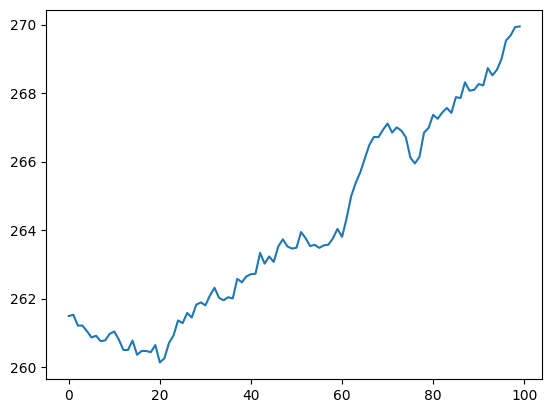

In [24]:
import matplotlib.pyplot as plt
exmitxx = np.array(emit_mon.gemitt_x.tolist())
plt.plot(exmitxx*1e12)